In [1]:
%autosave 0
import os
import glob
import numpy 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np 
import tensorflow as tf
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import scatter_matrix 
from numpy import set_printoptions
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.compose import ColumnTransformer
from datetime import datetime
from mlflow import log_metric, log_param

set_printoptions(precision=0)
pd.set_option("display.precision", 2)
pd.option_context('display.float_format', '{:0f}'.format);

seed = 15
tf.random.set_seed(seed)
# tf.set_random_seed(seed)
numpy.random.seed(seed)

Autosave disabled


# création du dataset final

récupération de tous les fichiers csv commençant par dataset_final 

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('../csv/dataset_final_*.{}'.format(extension))]

concaténation de tous les fichiers récupérés afin d'en obtenir qu'un seul

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "../csv/dataset_final.csv", index=False, encoding='utf-8-sig')

# préprocessing du dataset

récupération du fichier csv concaténé précédement

In [4]:
# Importation du fichier csv dans un dataframe
df_train_full = read_csv('../csv/dataset_final.csv', index_col=0)
df_train_full.head()

,publish_date,city,departement,region,titre,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage,output
ref,,,,,,,,,,,,,,
/fr/properties/33679a-0356.htm,NaN,mimbaste,landes,aquitaine,Maison Mimbaste 6 pièces,maison,123.0,1089.0,6.0,4.0,False,False,True,115000
/fr/properties/184125a-74ea885b.htm,2020-03-26,bordeaux,gironde,aquitaine,A vendre maison duplex de type T4 avec 3 chamb...,maison,NaN,NaN,NaN,NaN,False,False,False,560000
/fr/properties/31214a-15056822.htm,2020-03-26,bergerac,dordogne,aquitaine,Maison,maison,122.0,1000.0,5.0,3.0,True,False,True,201000
/fr/properties/54830a-h20190208n2.htm,2020-03-25,bordeaux,gironde,aquitaine,Bordeaux Bocage appartement T5 en duplex,appartement,222.0,NaN,8.0,5.0,False,False,False,1500000
/fr/properties/54830a-e20200108.htm,2020-03-25,libourne,gironde,aquitaine,Libourne Plein Centre,autre,210.0,NaN,8.0,3.0,False,False,False,325000


mise en forme du dataframe

In [5]:
# df_train_full = df_train_full.set_index('ref')
df_train_full = df_train_full.drop(columns=['titre','publish_date'])
print(df_train_full.shape)
df_train_full.head(5)

(1200, 12)


,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage,output
ref,,,,,,,,,,,,
/fr/properties/33679a-0356.htm,mimbaste,landes,aquitaine,maison,123.0,1089.0,6.0,4.0,False,False,True,115000
/fr/properties/184125a-74ea885b.htm,bordeaux,gironde,aquitaine,maison,NaN,NaN,NaN,NaN,False,False,False,560000
/fr/properties/31214a-15056822.htm,bergerac,dordogne,aquitaine,maison,122.0,1000.0,5.0,3.0,True,False,True,201000
/fr/properties/54830a-h20190208n2.htm,bordeaux,gironde,aquitaine,appartement,222.0,NaN,8.0,5.0,False,False,False,1500000
/fr/properties/54830a-e20200108.htm,libourne,gironde,aquitaine,autre,210.0,NaN,8.0,3.0,False,False,False,325000


In [6]:
df_train_full.describe()

,living_area_m2,lot_size_m2,nb_room,nb_bedroom,output
count,1155.00,9.33e+02,998.00,1012.00,1.20e+03
mean,252.33,1.59e+04,6.27,4.16,4.14e+05
std,556.32,7.05e+04,2.98,1.87,4.26e+05
min,2.00,1.70e+01,2.00,2.00,1.40e+04
25%,107.00,8.79e+02,4.00,3.00,1.80e+05
50%,165.00,2.00e+03,6.00,4.00,2.98e+05
75%,240.00,6.00e+03,8.00,5.00,4.90e+05
max,15000.00,1.52e+06,30.00,18.00,5.75e+06


split du dataframe en input et output

In [7]:
Y_trainfull = df_train_full['output']
X_trainfull = df_train_full.drop('output', axis=1)

In [8]:
print(Y_trainfull.shape)
print(X_trainfull.shape)

(1200,)
(1200, 11)


Récupération de la liste des villes

In [9]:
list_ville = X_trainfull["city"].unique()
list_departement = X_trainfull["departement"].unique()
list_region = X_trainfull["region"].unique()

In [10]:
df_ville = pd.DataFrame(list_ville, columns = ['list_ville'])
df_departement = pd.DataFrame(list_departement, columns = ['list_departement'])
df_region = pd.DataFrame(list_region, columns = ['list_region'])

frames = [df_ville, df_departement, df_region]

result = pd.concat(frames, axis=1)
result.to_csv('./templates/list_html.csv', index=False)

# Traitement des variables catégorielles

Sélection de toutes les colonnes concernant les variables catégorielles

In [11]:
cat_columns = ['city', 'departement', 'region', 'type']

création des pipelines onehotencoder afin de transformer les variables catégorielles en quantitatives

In [12]:
city_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['city'].unique()]))
])

In [13]:
departement_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['departement'].unique()]))
])

In [14]:
region_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['region'].unique()]))
])

In [15]:
type_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['type'].unique()]))
])

# Traitement des valeurs manquantes

Détection de la présence de valeurs manquantes

In [16]:
df_train_full.isna().any()

city              False
departement       False
region            False
type              False
living_area_m2     True
lot_size_m2        True
nb_room            True
nb_bedroom         True
pool              False
cellar            False
garage            False
output            False
dtype: bool

Sélection des colonnes de valeurs quantitatives

In [17]:
boolean_columns = ['pool', 'cellar', 'garage']
area_column = ['living_area_m2']
ground_column = ['lot_size_m2']
nb_room_column = ['nb_room']
nb_bedroom_column = ['nb_bedroom']

Création des pipelines gérant les valeurs manquantes dans les colonnes de valeurs quantitatives

In [18]:
area_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [19]:
ground_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [20]:
room_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

In [21]:
bedroom_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

# Construction du pipeline de pré-traitement

In [22]:
preprocess_pipe = ColumnTransformer(transformers=[
    ('city', city_pipe, ['city']),
    ('departement', departement_pipe, ['departement']),
    ('region', region_pipe, ['region']),
    ('type', type_pipe, ['type']),
    ('area', area_pipe, area_column),
    ('ground', ground_pipe, ground_column),
    ('room', room_pipe, nb_room_column),
    ('bedroom', bedroom_pipe, nb_bedroom_column),
])

# Choix du modèle et intégration dans la pipeline

Création de la fonction calculant la valeur moyenne absolut en pourcentage d'erreur

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

Création de la fonction de test de différents modèles

In [24]:
def mae_model(preprocess_pipe, model):

    full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

    X_train, X_val, Y_train, Y_val = train_test_split(X_trainfull, Y_trainfull,
                                                      test_size = 0.2, random_state = seed)

    full_pipe.fit(X_train, Y_train);

    y_train_pred = full_pipe.predict(X_train)
    y_val_pred = full_pipe.predict(X_val)

    mae_train = round(mean_absolute_percentage_error(Y_train, y_train_pred), 0)
    mae_val = round(mean_absolute_percentage_error(Y_val, y_val_pred), 0)

    return mae_train, mae_val

Liste des différents modèles

In [29]:
lin = LinearRegression()
log = LogisticRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
bag = BaggingRegressor()
xgb = XGBRegressor()
xgb_rf = XGBRFRegressor()

In [30]:
models = [lin, log, tree, rf, bag, xgb, xgb_rf]

calcul du MAPE

In [31]:
errors = []
for model in models:
    errors += [mae_model(preprocess_pipe, model)]

print(errors)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[(39.0, 73.0), (343.0, 378.0), (0.0, 66.0), (18.0, 65.0), (19.0, 78.0), (27.0, 79.0), (78.0, 103.0)]


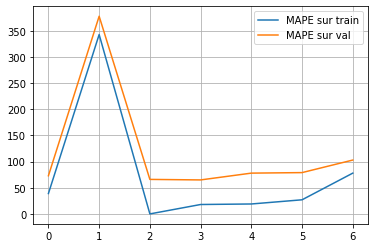

In [32]:
plt.plot(errors);
plt.grid();
plt.legend(['MAPE sur train', 'MAPE sur val']);

Du graphique précédent, nous choisissons de conserver le modèle 5 à savoir le modèle xgbregressor

# Génération du modèle retenu

In [34]:
model = rf

In [35]:
full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

In [36]:
full_pipe.fit(X_trainfull, Y_trainfull);

## exportation du modèle

In [37]:
# suppression du fichier si un ancien modèle existe
if os.path.exists('../models/full_pipe.file'):
    os.remove('../models/full_pipe.file')
else:
    print("Impossible de supprimer le fichier car il n'existe pas")

In [38]:
model_file_name = "../models/full_pipe_" + str(datetime.today())+ ".file"
last_model_name = "../models/full_pipe.file"

In [39]:
pickle.dump(full_pipe, open(model_file_name, "wb" ))
pickle.dump(full_pipe, open(last_model_name, "wb" ))

# Prédictions

## chargement du modèle

In [40]:
full_pipe = pickle.load(open(last_model_name, "rb"))

In [41]:
type(full_pipe)

sklearn.pipeline.Pipeline

## prédiction sur trainfull complet

In [42]:
X_trainfull

,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage
ref,,,,,,,,,,,
/fr/properties/33679a-0356.htm,mimbaste,landes,aquitaine,maison,123.0,1089.0,6.0,4.0,False,False,True
/fr/properties/184125a-74ea885b.htm,bordeaux,gironde,aquitaine,maison,NaN,NaN,NaN,NaN,False,False,False
/fr/properties/31214a-15056822.htm,bergerac,dordogne,aquitaine,maison,122.0,1000.0,5.0,3.0,True,False,True
/fr/properties/54830a-h20190208n2.htm,bordeaux,gironde,aquitaine,appartement,222.0,NaN,8.0,5.0,False,False,False
/fr/properties/54830a-e20200108.htm,libourne,gironde,aquitaine,autre,210.0,NaN,8.0,3.0,False,False,False
/fr/properties/13787a-3018.htm,monpazier,dordogne,aquitaine,maison,70.0,17.0,NaN,2.0,False,False,False
/fr/properties/54830a-y20191006.htm,quinsac,gironde,aquitaine,maison,78.0,NaN,3.0,2.0,False,False,True
/fr/properties/54830a-f20200109.htm,bazas,gironde,aquitaine,maison,110.0,1275.0,6.0,4.0,False,False,True
/fr/properties/54830a-b20200304.htm,gujan-mestras,gironde,aquitaine,autre,56.0,NaN,4.0,2.0,False,False,False


In [43]:
y_train_pred = full_pipe.predict(X_trainfull)

In [44]:
mape_train = round(mean_absolute_percentage_error(Y_trainfull, y_train_pred), 0)
print('MAPE sur train : ', mape_train, '%')

MAPE sur train :  19.0 %


In [45]:
trainfull_pred = pd.DataFrame(y_train_pred)
trainfull_pred.to_csv('../csv/trainfull_pred.csv', index=False)
Y_trainfull.to_csv('../csv/Y_trainfull.csv', index=False)

## prédiction sur valeur unique

In [46]:
new_value = pd.DataFrame(data = [
    ['bordeaux', 'gironde', 'aquitaine', 'appartement', 54, 12, 1, 1, 'True', 'True', 'True']
    ], index = ['test'], columns = X_trainfull.columns)

new_value.index.name = 'ref'
new_value

,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage
ref,,,,,,,,,,,
test,bordeaux,gironde,aquitaine,appartement,54,12,1,1,True,True,True


In [47]:
full_pipe.predict(new_value)

array([342639.])

# Enregistrement des résultats si voulus (mettre log = True)
-> accessible sous localhost:3000

In [48]:
log_param("X_trainfull.shape", X_trainfull.shape)
log_metric("MAPE sur train", mape_train)

/opt/conda/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import (
